Импорт необходимых библиотек

In [55]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import math
import random
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import optuna


/opt/anaconda3/envs/RL/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Агент на нейронных сетях

In [9]:
# Память для набора всевозможных состоящий
class ReplayBuffer(object):
    
    def __init__(self, capacity):
        self.Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
        self.memory = deque([], maxlen=capacity)

    # Добавляем элемент в буфер
    def push(self, *args):
        self.memory.append(self.Transition(*args))

    # Выгружаем из памяти батч для обучения
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [78]:
# Полносвязная нейронная сеть для алгоритма DQN
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.bn = nn.BatchNorm1d(128)  # Добавляем батч-нормализацию после первого слоя
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        # x = F.relu(self.bn1(self.layer1(x)))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [101]:
# Агент для метода DQN
class DeepAgent:
    # Конструктор 
    def __init__(self, env, 
                 LR=0.0001, EPS_START=0.9, EPS_END=0.05, EPS_DECAY=10000, DF=0.99, 
                 TAU=0.005, FULL_MEMORY_LENGTH=10000, BATCH_SIZE = 128, DEVICE='cpu'):
        # Среда
        self.env = env
        # Скорость обучения
        self.learning_rate = LR
        # Величина дисконтирования
        self.discount_factor = DF
        # Динамика жадности
        self.epsilon = EPS_START
        self.__eps_start = EPS_START
        self.__eps_end = EPS_END
        self.__eps_decay = EPS_DECAY
        # Выбор размещения нейронных сетей
        self.device = DEVICE
        # Размер батча
        self.batch_size = BATCH_SIZE
        # Температура мягкого обучения
        self.tau = TAU
        # Определяем нейронные сети целевую и политики
        # Первый параметр определяет количество наблюдений, второе число действий
        self.policy_net = DQN(len(self.env.reset()[0]), self.env.action_space.n).to(self.device)
        self.target_net = DQN(len(self.env.reset()[0]), self.env.action_space.n).to(self.device)
        # Подгружаем в целевую сеть коэффициенты из сети политики
        self.target_net.load_state_dict(self.policy_net.state_dict())
        # Задаём оптимайзер для нейронной сети
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.learning_rate, amsgrad=True)
        # Инициализируем Replay Memory buffer
        self.memory = ReplayBuffer(FULL_MEMORY_LENGTH)
        # Длины траекторий по эпизодам
        self.steps = []
        # Итоговое вознаграждение по эпизодам
        self.rewards = []

    # эпсилон-жадная стратегия выбора действия
    def __epsilon_greedy_action(self, state):
        
        # С вероятностью epsilon выбираем случайное действие
        # в противном случае берём лучшее действия исходя из текущей оценки политики
        if np.random.uniform(0, 1) < self.epsilon:
            with torch.no_grad():
                return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)
        else:
            # t.max(1) вернет наибольшее значение столбца в каждой строке.
            # Второй столбец в результате max - это индекс того места, 
            # где был найден максимальный элемент, 
            # поэтому мы выбираем действие с наибольшим ожидаемым вознаграждением.
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)

    def __optimize_model(self):
        # Алгоритм работает только при размере буфера больше или равным размеру батча
        if len(self.memory) < self.batch_size:
            return
        
        # Получаем из памяти батч
        transitions = self.memory.sample(self.batch_size)
        # Преобразовали его в namedtuple
        batch = self.memory.Transition(*zip(*transitions))

        # Вычислить маску нефинальных состояний и соединить элементы батча
        # (финальным состоянием должно быть то, после которого моделирование закончилось)

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=self.device, dtype=torch.bool)
    
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
        # Собираем батчи для состояний, действий и наград
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Вычислить Q(s_t, a) - модель вычисляет Q(s_t), 
        # затем мы выбираем столбцы предпринятых действий. 
        # Это те действия, которые были бы предприняты для каждого состояния партии в соответствии с policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Вычислить V(s_{t+1}) для всех следующих состояний.
        # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются 
        # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
        # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния, 
        # либо 0, если состояние было финальным.
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Вычисляем ожидаемые Q значения
        expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

        # Объединяем все в общий лосс
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Готовим градиент
        self.optimizer.zero_grad()
        loss.backward()
        # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
    
        self.optimizer.step()

    # Обучение Агента
    def train(self, num_episodes=50, logfreq=20):
        # Обнуляем прошлый опыт
        self.rewards, self.steps = [], []

        for episode in tqdm(range(num_episodes)):
            episode_reward, steps = 0, 0
            done = False
            # Для каждого эпизода инициализируем начальное состояние
            state, _ = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            
            # выполняем действия пока не получим флаг done
            # t - считает сколько шагов успели сделать
            while not done:
                # выбираем действие [0, 1]
                
                action = self.__epsilon_greedy_action(state)
                # Делаем шаг
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                # Объединяем done по двум конечным состояниям
                done = terminated or truncated
                # Вычисляем вознаграждение за эпизод
                episode_reward += reward
                # Преобразуем в тензор
                reward = torch.tensor([reward], dtype=torch.float32, device=self.device)
                # присваиваем следующее состояние
                next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0) if not terminated else None
                # отправляем в память
                self.memory.push(state, action, next_state, reward)
                # переходим на следующее состояние
                state = next_state
                # запускаем обучение сети
                self.__optimize_model()

                # делаем "мягкое" обновление весов
                # θ′ ← τ θ + (1 −τ )θ′
                # Обновление весов целевой сети "мягким" способом
                with torch.no_grad():
                    for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
                        target_param.data.copy_(self.tau * policy_param.data + (1 - self.tau) * target_param.data)
                # Считаем длину траектории
                steps += 1
            # Завершение траектории текущего эпизода

            # добавляем в массив продолжительность эпизода и вознаграждение
            self.steps.append(steps)
            self.rewards.append(episode_reward)
            # Выводим информацию об успешности обучения
            if (episode+1) % logfreq == 0:
                print(f'Эдизод #{episode+1}, \nсреднее вознаграждение за последние 5 эпизодов: {np.mean(self.rewards[-5:]): .0f}\n epsilon = {self.epsilon: .3f}')
            # Уменьшаем критерий жадности
            self.epsilon = self.__eps_end + (self.__eps_start - self.__eps_end) * \
                math.exp(-1. * sum(self.steps) / self.__eps_decay)

    # Отрисовка результатов обучения
    # Выводим вознаграждение и длину траектории
    def plot_rewards(self, window_size=10):
        # Сгладим графики
        smoothed_rewards = pd.Series(self.rewards).rolling(window_size, min_periods=window_size).mean()
        smoothed_steps = pd.Series(self.steps).rolling(window_size, min_periods=window_size).mean()

        plt.figure(figsize=(8, 12))
        plt.subplot(2, 1, 1)
        plt.plot(smoothed_rewards)
        plt.xlabel('Эпизод')
        plt.ylabel('Суммарное вознаграждение')
        plt.title('Оценка вознаграждения')

        plt.subplot(2, 1, 2)
        plt.plot(smoothed_steps)
        plt.xlabel('Эпизод')
        plt.ylabel('Длина траектории')
        plt.title('Оценка длины траектории')

        plt.tight_layout()
        plt.show()

# Обучение агента

  5%|▌         | 20/400 [00:09<03:31,  1.80it/s]

Эдизод #20, 
среднее вознаграждение за последние 5 эпизодов: -147
 epsilon =  0.749


 10%|█         | 40/400 [00:31<06:25,  1.07s/it]

Эдизод #40, 
среднее вознаграждение за последние 5 эпизодов: -14
 epsilon =  0.530


 15%|█▌        | 60/400 [01:25<24:29,  4.32s/it]

Эдизод #60, 
среднее вознаграждение за последние 5 эпизодов:  43
 epsilon =  0.239


 20%|██        | 80/400 [02:19<18:33,  3.48s/it]

Эдизод #80, 
среднее вознаграждение за последние 5 эпизодов: -15
 epsilon =  0.115


 25%|██▌       | 100/400 [03:02<12:20,  2.47s/it]

Эдизод #100, 
среднее вознаграждение за последние 5 эпизодов:  41
 epsilon =  0.081


 30%|███       | 120/400 [03:51<16:48,  3.60s/it]

Эдизод #120, 
среднее вознаграждение за последние 5 эпизодов: -35
 epsilon =  0.063


 35%|███▌      | 140/400 [05:01<18:23,  4.24s/it]

Эдизод #140, 
среднее вознаграждение за последние 5 эпизодов: -46
 epsilon =  0.054


 40%|████      | 160/400 [06:21<14:25,  3.61s/it]

Эдизод #160, 
среднее вознаграждение за последние 5 эпизодов:  201
 epsilon =  0.051


 45%|████▌     | 180/400 [07:15<06:05,  1.66s/it]

Эдизод #180, 
среднее вознаграждение за последние 5 эпизодов:  108
 epsilon =  0.050


 50%|█████     | 200/400 [07:46<04:24,  1.32s/it]

Эдизод #200, 
среднее вознаграждение за последние 5 эпизодов:  168
 epsilon =  0.050


 55%|█████▌    | 220/400 [08:24<05:39,  1.89s/it]

Эдизод #220, 
среднее вознаграждение за последние 5 эпизодов:  140
 epsilon =  0.050


 60%|██████    | 240/400 [09:06<05:19,  2.00s/it]

Эдизод #240, 
среднее вознаграждение за последние 5 эпизодов:  193
 epsilon =  0.050


 65%|██████▌   | 260/400 [09:56<04:22,  1.87s/it]

Эдизод #260, 
среднее вознаграждение за последние 5 эпизодов:  248
 epsilon =  0.050


 70%|███████   | 280/400 [10:28<03:00,  1.51s/it]

Эдизод #280, 
среднее вознаграждение за последние 5 эпизодов:  265
 epsilon =  0.050


 75%|███████▌  | 300/400 [10:53<01:44,  1.04s/it]

Эдизод #300, 
среднее вознаграждение за последние 5 эпизодов:  164
 epsilon =  0.050


 80%|████████  | 320/400 [11:24<01:56,  1.46s/it]

Эдизод #320, 
среднее вознаграждение за последние 5 эпизодов:  254
 epsilon =  0.050


 85%|████████▌ | 340/400 [11:50<01:27,  1.45s/it]

Эдизод #340, 
среднее вознаграждение за последние 5 эпизодов:  270
 epsilon =  0.050


 90%|█████████ | 360/400 [12:24<00:59,  1.49s/it]

Эдизод #360, 
среднее вознаграждение за последние 5 эпизодов:  181
 epsilon =  0.050


 95%|█████████▌| 380/400 [12:57<00:24,  1.24s/it]

Эдизод #380, 
среднее вознаграждение за последние 5 эпизодов:  160
 epsilon =  0.050


100%|██████████| 400/400 [13:35<00:00,  2.04s/it]

Эдизод #400, 
среднее вознаграждение за последние 5 эпизодов:  253
 epsilon =  0.050


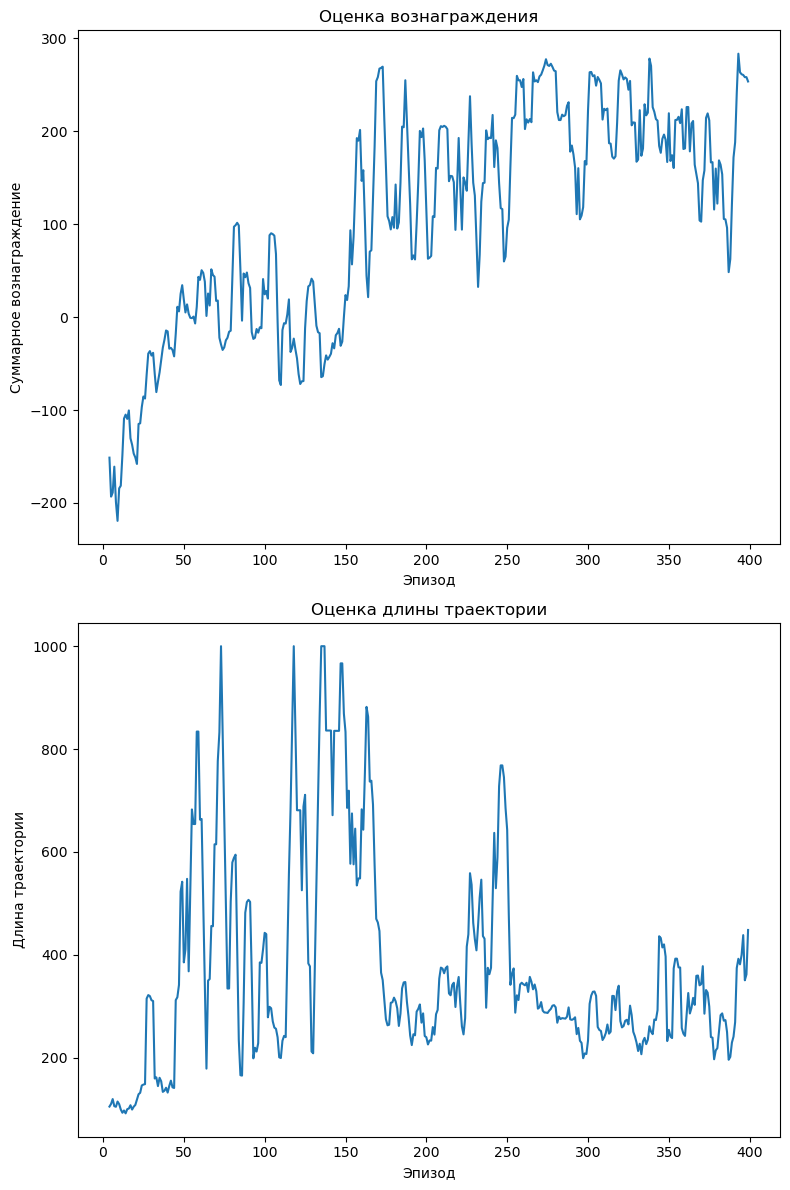

In [106]:
# Обучаем агента с различными параметрами
agent = DeepAgent(gym.make('LunarLander-v2', continuous=False), 
                  LR=1E-4, BATCH_SIZE=128, EPS_DECAY=10E3)
                #   DEVICE="mps" if torch.backends.mps.is_available() else "cpu")
agent.train(num_episodes=400)
agent.plot_rewards(5)

  5%|▌         | 20/400 [00:13<04:53,  1.29it/s]

Эдизод #20, 
среднее вознаграждение за последние 5 эпизодов: -116
 epsilon =  0.757


 10%|█         | 40/400 [00:35<06:06,  1.02s/it]

Эдизод #40, 
среднее вознаграждение за последние 5 эпизодов: -61
 epsilon =  0.589


 15%|█▌        | 60/400 [01:48<36:20,  6.41s/it]

Эдизод #60, 
среднее вознаграждение за последние 5 эпизодов: -85
 epsilon =  0.277


 20%|██        | 80/400 [04:24<43:35,  8.17s/it]

Эдизод #80, 
среднее вознаграждение за последние 5 эпизодов: -47
 epsilon =  0.081


 25%|██▌       | 100/400 [06:39<35:20,  7.07s/it]

Эдизод #100, 
среднее вознаграждение за последние 5 эпизодов: -33
 epsilon =  0.055


 30%|███       | 120/400 [09:11<28:00,  6.00s/it]

Эдизод #120, 
среднее вознаграждение за последние 5 эпизодов: -28
 epsilon =  0.051


 35%|███▌      | 140/400 [11:12<15:22,  3.55s/it]

Эдизод #140, 
среднее вознаграждение за последние 5 эпизодов: -59
 epsilon =  0.050


 40%|████      | 160/400 [13:37<27:05,  6.77s/it]

Эдизод #160, 
среднее вознаграждение за последние 5 эпизодов: -41
 epsilon =  0.050


 45%|████▌     | 180/400 [16:08<27:31,  7.51s/it]

Эдизод #180, 
среднее вознаграждение за последние 5 эпизодов:  17
 epsilon =  0.050


 50%|█████     | 200/400 [18:08<15:01,  4.51s/it]

Эдизод #200, 
среднее вознаграждение за последние 5 эпизодов:  120
 epsilon =  0.050


 55%|█████▌    | 220/400 [20:04<16:09,  5.39s/it]

Эдизод #220, 
среднее вознаграждение за последние 5 эпизодов:  185
 epsilon =  0.050


 60%|██████    | 240/400 [21:33<11:36,  4.36s/it]

Эдизод #240, 
среднее вознаграждение за последние 5 эпизодов:  168
 epsilon =  0.050


 65%|██████▌   | 260/400 [22:47<07:00,  3.01s/it]

Эдизод #260, 
среднее вознаграждение за последние 5 эпизодов:  227
 epsilon =  0.050


 70%|███████   | 280/400 [24:18<13:02,  6.52s/it]

Эдизод #280, 
среднее вознаграждение за последние 5 эпизодов:  131
 epsilon =  0.050


 75%|███████▌  | 300/400 [26:06<07:41,  4.62s/it]

Эдизод #300, 
среднее вознаграждение за последние 5 эпизодов:  186
 epsilon =  0.050


 80%|████████  | 320/400 [28:03<08:29,  6.37s/it]

Эдизод #320, 
среднее вознаграждение за последние 5 эпизодов:  154
 epsilon =  0.050


 85%|████████▌ | 340/400 [29:09<03:23,  3.40s/it]

Эдизод #340, 
среднее вознаграждение за последние 5 эпизодов:  146
 epsilon =  0.050


 90%|█████████ | 360/400 [30:40<02:35,  3.88s/it]

Эдизод #360, 
среднее вознаграждение за последние 5 эпизодов:  251
 epsilon =  0.050


 95%|█████████▌| 380/400 [32:49<01:57,  5.87s/it]

Эдизод #380, 
среднее вознаграждение за последние 5 эпизодов:  198
 epsilon =  0.050


100%|██████████| 400/400 [34:31<00:00,  5.18s/it]

Эдизод #400, 
среднее вознаграждение за последние 5 эпизодов:  218
 epsilon =  0.050


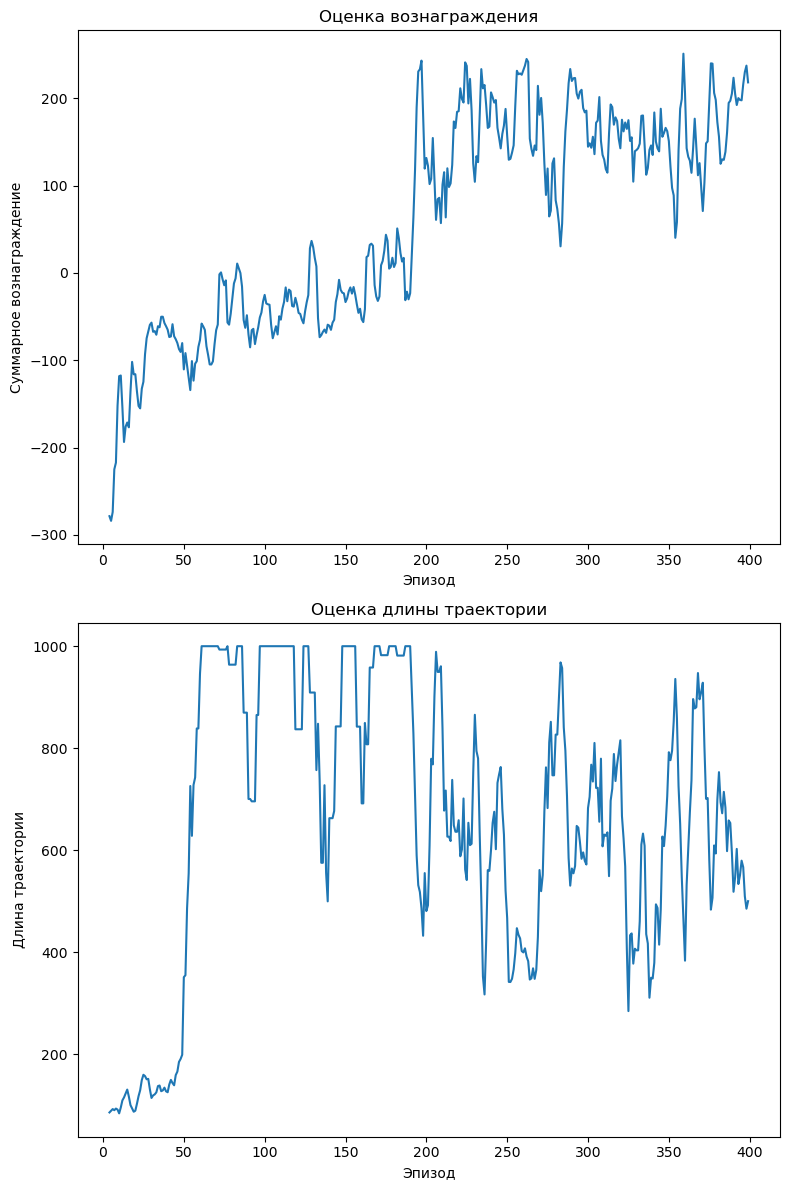

In [108]:
# Обучаем агента с различными параметрами
agent = DeepAgent(gym.make('LunarLander-v2', continuous=False), 
                  LR=1E-4, BATCH_SIZE=256, EPS_DECAY=10E3, TAU=0.05)
                #   DEVICE="mps" if torch.backends.mps.is_available() else "cpu")
agent.train(num_episodes=400)
agent.plot_rewards(5)

  2%|▏         | 20/1000 [00:14<14:36,  1.12it/s]

Эдизод #20, 
среднее вознаграждение за последние 5 эпизодов: -162
 epsilon =  0.871


  4%|▍         | 40/1000 [00:31<13:52,  1.15it/s]

Эдизод #40, 
среднее вознаграждение за последние 5 эпизодов: -133
 epsilon =  0.840


  6%|▌         | 60/1000 [00:48<09:39,  1.62it/s]

Эдизод #60, 
среднее вознаграждение за последние 5 эпизодов: -82
 epsilon =  0.812


  8%|▊         | 80/1000 [01:09<16:01,  1.04s/it]

Эдизод #80, 
среднее вознаграждение за последние 5 эпизодов: -91
 epsilon =  0.781


 10%|█         | 100/1000 [01:28<14:02,  1.07it/s]

Эдизод #100, 
среднее вознаграждение за последние 5 эпизодов: -104
 epsilon =  0.751


 12%|█▏        | 120/1000 [01:46<12:26,  1.18it/s]

Эдизод #120, 
среднее вознаграждение за последние 5 эпизодов: -71
 epsilon =  0.725


 14%|█▍        | 140/1000 [02:06<15:01,  1.05s/it]

Эдизод #140, 
среднее вознаграждение за последние 5 эпизодов: -68
 epsilon =  0.698


 16%|█▌        | 160/1000 [02:27<14:03,  1.00s/it]

Эдизод #160, 
среднее вознаграждение за последние 5 эпизодов: -78
 epsilon =  0.670


 18%|█▊        | 180/1000 [02:45<10:15,  1.33it/s]

Эдизод #180, 
среднее вознаграждение за последние 5 эпизодов: -72
 epsilon =  0.646


 20%|██        | 200/1000 [03:07<14:29,  1.09s/it]

Эдизод #200, 
среднее вознаграждение за последние 5 эпизодов: -36
 epsilon =  0.622


 22%|██▏       | 220/1000 [03:27<13:45,  1.06s/it]

Эдизод #220, 
среднее вознаграждение за последние 5 эпизодов: -51
 epsilon =  0.598


 24%|██▍       | 240/1000 [03:47<12:06,  1.05it/s]

Эдизод #240, 
среднее вознаграждение за последние 5 эпизодов: -59
 epsilon =  0.575


 26%|██▌       | 260/1000 [04:16<13:44,  1.11s/it]

Эдизод #260, 
среднее вознаграждение за последние 5 эпизодов: -51
 epsilon =  0.544


 28%|██▊       | 280/1000 [04:40<11:10,  1.07it/s]

Эдизод #280, 
среднее вознаграждение за последние 5 эпизодов: -24
 epsilon =  0.521


 30%|███       | 300/1000 [05:24<34:02,  2.92s/it]

Эдизод #300, 
среднее вознаграждение за последние 5 эпизодов: -101
 epsilon =  0.480


 32%|███▏      | 320/1000 [06:40<31:46,  2.80s/it]  

Эдизод #320, 
среднее вознаграждение за последние 5 эпизодов: -42
 epsilon =  0.419


 34%|███▍      | 340/1000 [07:22<59:00,  5.36s/it]

Эдизод #340, 
среднее вознаграждение за последние 5 эпизодов:  54
 epsilon =  0.396


 36%|███▌      | 360/1000 [09:10<1:02:52,  5.90s/it]

Эдизод #360, 
среднее вознаграждение за последние 5 эпизодов:  17
 epsilon =  0.329


 38%|███▊      | 380/1000 [10:57<1:01:06,  5.91s/it]

Эдизод #380, 
среднее вознаграждение за последние 5 эпизодов: -16
 epsilon =  0.281


 40%|████      | 400/1000 [12:56<53:17,  5.33s/it]  

Эдизод #400, 
среднее вознаграждение за последние 5 эпизодов:  82
 epsilon =  0.237


 42%|████▏     | 420/1000 [15:26<1:14:35,  7.72s/it]

Эдизод #420, 
среднее вознаграждение за последние 5 эпизодов:  136
 epsilon =  0.198


 44%|████▍     | 440/1000 [17:15<26:18,  2.82s/it]  

Эдизод #440, 
среднее вознаграждение за последние 5 эпизодов:  139
 epsilon =  0.175


 46%|████▌     | 460/1000 [18:31<40:49,  4.54s/it]

Эдизод #460, 
среднее вознаграждение за последние 5 эпизодов:  128
 epsilon =  0.164


 48%|████▊     | 480/1000 [19:47<23:57,  2.76s/it]

Эдизод #480, 
среднее вознаграждение за последние 5 эпизодов:  104
 epsilon =  0.153


 50%|█████     | 500/1000 [20:59<30:46,  3.69s/it]

Эдизод #500, 
среднее вознаграждение за последние 5 эпизодов:  220
 epsilon =  0.146


 52%|█████▏    | 520/1000 [22:13<31:04,  3.88s/it]

Эдизод #520, 
среднее вознаграждение за последние 5 эпизодов:  184
 epsilon =  0.139


 54%|█████▍    | 540/1000 [23:58<36:53,  4.81s/it]

Эдизод #540, 
среднее вознаграждение за последние 5 эпизодов:  128
 epsilon =  0.130


 56%|█████▌    | 560/1000 [26:11<54:13,  7.39s/it]

Эдизод #560, 
среднее вознаграждение за последние 5 эпизодов:  73
 epsilon =  0.123


 58%|█████▊    | 580/1000 [28:28<52:16,  7.47s/it]  

Эдизод #580, 
среднее вознаграждение за последние 5 эпизодов:  14
 epsilon =  0.117


 60%|██████    | 600/1000 [29:48<22:49,  3.42s/it]

Эдизод #600, 
среднее вознаграждение за последние 5 эпизодов:  238
 epsilon =  0.114


 62%|██████▏   | 620/1000 [31:46<41:55,  6.62s/it]

Эдизод #620, 
среднее вознаграждение за последние 5 эпизодов:  120
 epsilon =  0.110


 64%|██████▍   | 640/1000 [33:42<28:04,  4.68s/it]

Эдизод #640, 
среднее вознаграждение за последние 5 эпизодов:  222
 epsilon =  0.108


 66%|██████▌   | 660/1000 [35:45<38:00,  6.71s/it]

Эдизод #660, 
среднее вознаграждение за последние 5 эпизодов:  88
 epsilon =  0.106


 68%|██████▊   | 680/1000 [37:27<20:44,  3.89s/it]

Эдизод #680, 
среднее вознаграждение за последние 5 эпизодов:  166
 epsilon =  0.105


 70%|███████   | 700/1000 [39:07<26:08,  5.23s/it]

Эдизод #700, 
среднее вознаграждение за последние 5 эпизодов:  136
 epsilon =  0.104


 72%|███████▏  | 720/1000 [40:45<27:45,  5.95s/it]

Эдизод #720, 
среднее вознаграждение за последние 5 эпизодов:  200
 epsilon =  0.103


 74%|███████▍  | 740/1000 [42:12<15:56,  3.68s/it]

Эдизод #740, 
среднее вознаграждение за последние 5 эпизодов:  255
 epsilon =  0.102


 76%|███████▌  | 760/1000 [43:49<20:09,  5.04s/it]

Эдизод #760, 
среднее вознаграждение за последние 5 эпизодов:  200
 epsilon =  0.102


 78%|███████▊  | 780/1000 [45:15<23:02,  6.28s/it]

Эдизод #780, 
среднее вознаграждение за последние 5 эпизодов:  184
 epsilon =  0.102


 80%|████████  | 800/1000 [47:04<19:53,  5.97s/it]

Эдизод #800, 
среднее вознаграждение за последние 5 эпизодов:  187
 epsilon =  0.101


 82%|████████▏ | 820/1000 [48:24<11:24,  3.80s/it]

Эдизод #820, 
среднее вознаграждение за последние 5 эпизодов:  235
 epsilon =  0.101


 84%|████████▍ | 840/1000 [49:41<10:48,  4.06s/it]

Эдизод #840, 
среднее вознаграждение за последние 5 эпизодов:  230
 epsilon =  0.101


 86%|████████▌ | 860/1000 [50:54<07:29,  3.21s/it]

Эдизод #860, 
среднее вознаграждение за последние 5 эпизодов:  260
 epsilon =  0.101


 88%|████████▊ | 880/1000 [52:12<09:21,  4.68s/it]

Эдизод #880, 
среднее вознаграждение за последние 5 эпизодов:  242
 epsilon =  0.101


 90%|█████████ | 900/1000 [53:24<06:45,  4.06s/it]

Эдизод #900, 
среднее вознаграждение за последние 5 эпизодов:  207
 epsilon =  0.101


 92%|█████████▏| 920/1000 [54:34<04:12,  3.15s/it]

Эдизод #920, 
среднее вознаграждение за последние 5 эпизодов:  259
 epsilon =  0.100


 94%|█████████▍| 940/1000 [55:37<03:50,  3.84s/it]

Эдизод #940, 
среднее вознаграждение за последние 5 эпизодов:  259
 epsilon =  0.100


 96%|█████████▌| 960/1000 [56:37<02:01,  3.04s/it]

Эдизод #960, 
среднее вознаграждение за последние 5 эпизодов:  269
 epsilon =  0.100


 98%|█████████▊| 980/1000 [57:47<00:58,  2.91s/it]

Эдизод #980, 
среднее вознаграждение за последние 5 эпизодов:  273
 epsilon =  0.100


100%|██████████| 1000/1000 [58:46<00:00,  3.53s/it]

Эдизод #1000, 
среднее вознаграждение за последние 5 эпизодов:  251
 epsilon =  0.100


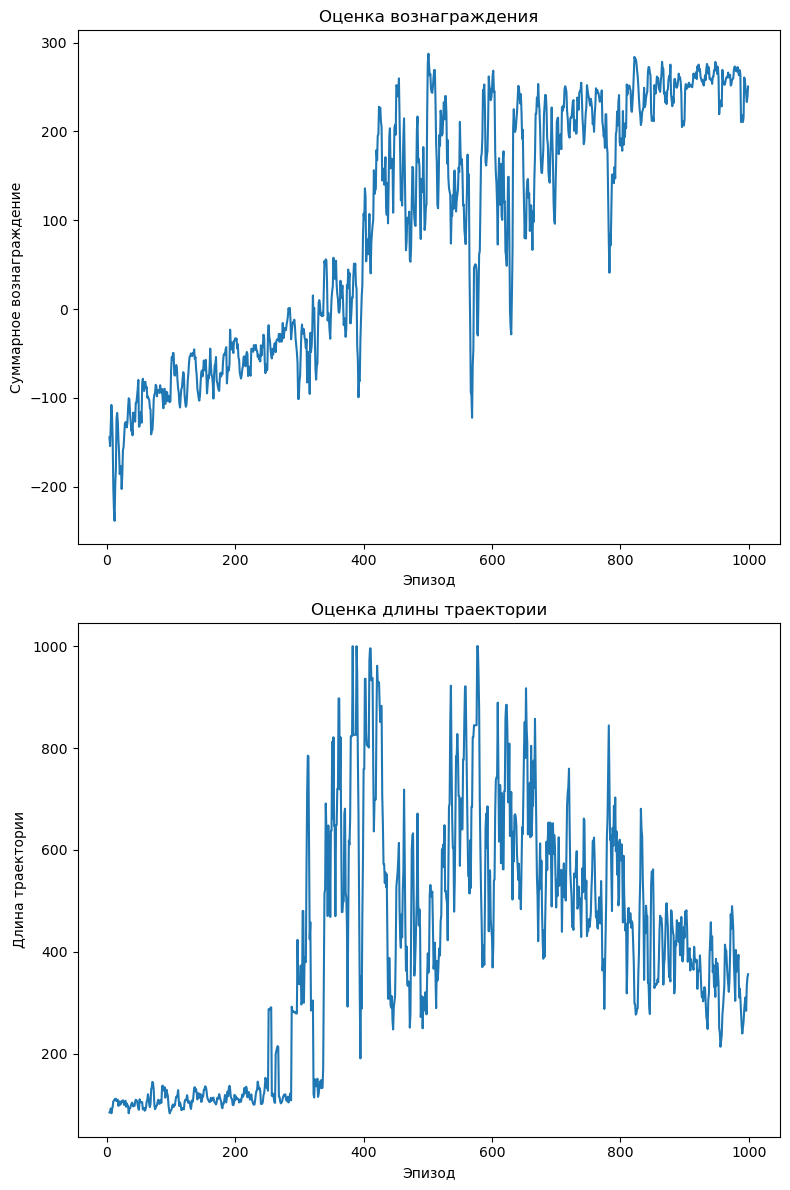

In [111]:
# Обучаем агента с различными параметрами
agent = DeepAgent(gym.make('LunarLander-v2', continuous=False), 
                  LR=1E-4, BATCH_SIZE=256, EPS_END=0.1, EPS_DECAY=50000, TAU=0.05)
                #   DEVICE="mps" if torch.backends.mps.is_available() else "cpu")
agent.train(num_episodes=1000)
agent.plot_rewards(5)

In [ ]:
# def objective(trial):
#     LR = trial.suggest_float('LR', 1e-5, 1e-2, log=True)
#     EPS = trial.suggest_float('EPS', 0.05, 0.20)
#     DF = trial.suggest_float('DF', 0.50, 0.95)
#     TAU = trial.suggest_float('TAU', 0.001, 0.1)
#     FULL_MEMORY_LENGTH = trial.suggest_int('FULL_MEMORY_LENGTH', 1000, 100000)
#     BATCH_SIZE = trial.suggest_int('BATCH_SIZE', 16, 256)

#     agent = DeepAgent(gym.make('LunarLander-v2', continuous=False), LR=LR, EPS=EPS, DF=DF, TAU=TAU, FULL_MEMORY_LENGTH=FULL_MEMORY_LENGTH, BATCH_SIZE=BATCH_SIZE)
#     agent.train(num_episodes=200)

#     # Вычисляем среднее вознаграждение за последние 20 эпизодов
#     last_20_rewards = agent.rewards[-20:]
#     mean_last_20_rewards = np.mean(last_20_rewards)

#     # Возвращаем среднее вознаграждение за последние 20 эпизодов
#     return -mean_last_20_rewards

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# best_params = study.best_params
# print("Best hyperparameters:", best_params)